<a href="https://colab.research.google.com/github/suchith1012/Mitosis-detection-based-on-features-from-breast-cancer-histology-slide-images/blob/main/Code/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdution 

In this article we are going to extract the features from the images and use optimizer technique and classifer to classify the Mitosis and Non Mitosis

Extracting data from zip file

In [ ]:
!unzip "/content/MandNM.zip" -d "/content"

Installing Libraries

In [2]:
!git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null
!cp -r scikit-hyperband/* .
!python setup.py install 2>/dev/null 1>/dev/null
!pip install scikit-optimize
!pip install sklearn-deap
!pip install tpot


In [40]:
import matplotlib.pyplot as plt
from skimage import io
import cv2
from sklearn.model_selection import GridSearchCV
import csv
import numpy as np
import os
from google.colab.patches import cv2_imshow
from os import path
from skimage.feature import hog
from skimage import data, color, exposure
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import svm
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
from hyperband import HyperbandSearchCV
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOTClassifier



## PCA 


In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.manifold import Isomap

def pca_reduction(data):
  pca = PCA(n_components=200)
  reduced_features = pca.fit_transform(hogArray_np)
  features = reduced_features.tolist()
  return features

## GridSearch

In [5]:
def grid_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_svm(x_train,x_test,y_train,y_test):
    param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly','linear','sigmoid']}
    svc=svm.SVC(probability=True)
    model=GridSearchCV(svc,param_grid)
    model.fit(x_train,y_train)
    print('The svm Model is trained well with the given images',model.best_params_)
    y_pred=model.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_pred,y_test)*100))
  def classify_rf(x_train,x_test,y_train,y_test):
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 'n_estimators': [1,10, 100,200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [15,20,30,50],'criterion' :['gini', 'entropy']}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train,y_train)
    print('The rf Model is trained well with the given images',CV_rfc.best_params_)
    y_rf_pred=CV_rfc.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': [2, 3, 5,10,15,20]}
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
    grid.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",grid.best_params_)
    result.append("KNN:"+str(grid.best_score_))
  classify_rf(x_train,x_test,y_train,y_test)
  classify_knn(x_train,x_test,y_train,y_test)
  classify_svm(x_train,x_test,y_train,y_test)
  return result







## Random Search optmizer

In [6]:
def random_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_rso_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid']}
    n_iter_search=20
    clf = svm.SVC(gamma='scale')
    Random_svm = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Random_svm.best_params_)
    result.append("svm:"+str(Random_svm.best_score_))
  def classify_rso_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    n_iter_search=20 
    clf_rf = RandomForestClassifier(random_state=0)
    Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Random_rf.best_params_)
    result.append("Random forest:"+str(Random_rf.best_score_))
  def classify_rso_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20)}
    n_iter_search=10
    clf_knn = KNeighborsClassifier()
    Random_knn = RandomizedSearchCV(clf_knn, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Random_knn.best_params_)
    result.append("KNN:"+str(Random_knn.best_score_))
  classify_rso_rf(x_train,x_test,y_train,y_test)
  classify_rso_knn(x_train,x_test,y_train,y_test)
  classify_rso_svm(x_train,x_test,y_train,y_test)
  return result







## Hyperband

In [7]:
def hyperband_opt(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_hb_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid'],'bootstrap': [True, False]}
    clf_hb_svm = svm.SVC(gamma='scale')
    hyper_hb_svm = HyperbandSearchCV(clf_hb_svm, param_distributions =rf_params,cv=3,min_iter=1,max_iter=50,scoring='roc_auc',resource_param='C')
    hyper_hb_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",hyper_hb_svm.best_params_)
    result.append("svm:"+str(hyper_hb_svm.best_score_))
  def classify_hb_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),'bootstrap': [True, False],"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    clf_hb_rf = RandomForestClassifier(random_state=0)
    hyper_rf = HyperbandSearchCV(clf_hb_rf, param_distributions =rf_params,cv=3,min_iter=10,max_iter=100,scoring='roc_auc')
    hyper_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",hyper_rf.best_params_)
    result.append("Random forest:"+str(hyper_rf.best_score_))
  def classify_hb_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),'bootstrap': [True, False]}
    clf_hb_knn = KNeighborsClassifier()
    hyper_knn = HyperbandSearchCV(clf_hb_knn, param_distributions =rf_params,cv=3,min_iter=1,max_iter=20,scoring='roc_auc',resource_param='n_neighbors')
    hyper_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",hyper_knn.best_params_)
    result.append("KNN:"+str(hyper_knn.best_score_))
  classify_hb_rf(x_train,x_test,y_train,y_test)
  classify_hb_knn(x_train,x_test,y_train,y_test)
  classify_hb_svm(x_train,x_test,y_train,y_test)
  return result







## Bayesian Optimization with Gaussian Process (BO-GP)

In [21]:
def bogp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_bogp_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C':[0.1,1,10,100],"kernel":['linear','poly','rbf','sigmoid']}
    clf_svm = svm.SVC(gamma='scale')
    Bayes_svm = BayesSearchCV(clf_svm, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(Bayes_svm.best_score_))
  def classify_bogp_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': Integer(10,100),"max_features":Integer(1,64),'max_depth': Integer(5,50),"min_samples_split":Integer(2,11),"min_samples_leaf":Integer(1,11),"criterion":['gini','entropy']}
    clf_bogp_rf = RandomForestClassifier(random_state=0)
    Bayes_rf = BayesSearchCV(clf_bogp_rf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Bayes_rf.best_params_)
    result.append("Random forest:"+str(Bayes_rf.best_score_))
  def classify_bogp_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': Integer(1,20)}
    clf_bogp_knn = KNeighborsClassifier()
    Bayes_knn = BayesSearchCV(clf_bogp_knn, rf_params,cv=3,n_iter=10, n_jobs=-1,scoring='accuracy')
    Bayes_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(Bayes_knn.best_score_))
  classify_bogp_rf(x_train,x_test,y_train,y_test)
  classify_bogp_knn(x_train,x_test,y_train,y_test)
  classify_bogp_svm(x_train,x_test,y_train,y_test)
  return result

## skopt.gp_minimize

In [27]:


def skopt_gp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_skgp_svm(x_train,x_test,y_train,y_test):
    reg = svm.SVC(gamma='scale')
    space  = [Real(0.01, 50, name='C'),Categorical(['linear','poly','rbf','sigmoid'], name='kernel')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_svm = gp_minimize(objective, space, n_calls=20, random_state=0)
    # print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(-res_svm.fun))
  def classify_skgp_rf(x_train,x_test,y_train,y_test):
    reg = RandomForestClassifier()
    space  = [Integer(10, 100, name='n_estimators'),Integer(5, 50, name='max_depth'),Integer(1, 64, name='max_features'),Integer(2, 11, name='min_samples_split'),Integer(1, 11, name='min_samples_leaf'),Categorical(['gini', 'entropy'], name='criterion'),]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    result.append("Random forest:"+str(-res_gp.fun))
  def classify_skgp_knn(x_train,x_test,y_train,y_test):
    reg = KNeighborsClassifier()
    space  = [Integer(1, 20, name='n_neighbors')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_knn = gp_minimize(objective, space, n_calls=10, random_state=0)
    # print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(-res_knn.fun))
  classify_skgp_rf(x_train,x_test,y_train,y_test)
  classify_skgp_knn(x_train,x_test,y_train,y_test)
  classify_skgp_svm(x_train,x_test,y_train,y_test)
  return result

## Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

In [33]:
def bo_tpe(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_botpe_svm(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'C': abs(float(params['C'])), "kernel":str(params['kernel'])}
      clf = svm.SVC(gamma='scale', **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'C': hp.normal('C', 0, 50),"kernel":hp.choice('kernel',['linear','poly','rbf','sigmoid'])}
    best_svm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("svm:"+str(best_svm))
  def classify_botpe_rf(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth']),'max_features': int(params['max_features']),"min_samples_split":int(params['min_samples_split']),"min_samples_leaf":int(params['min_samples_leaf']),"criterion":str(params['criterion'])}
      clf = RandomForestClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_estimators': hp.quniform('n_estimators', 10, 100, 1),'max_depth': hp.quniform('max_depth', 5, 50, 1),"max_features":hp.quniform('max_features', 1, 64, 1),"min_samples_split":hp.quniform('min_samples_split',2,11,1),"min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),"criterion":hp.choice('criterion',['gini','entropy'])}
    best_rf = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("Random forest:"+str(best_rf))
  def classify_botpe_knn(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_neighbors': abs(int(params['n_neighbors']))}
      clf = KNeighborsClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),}
    best_knn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
    result.append("KNN:"+str(best_knn))
  classify_botpe_rf(x_train,x_test,y_train,y_test)
  classify_botpe_knn(x_train,x_test,y_train,y_test)
  classify_botpe_svm(x_train,x_test,y_train,y_test)
  return result

## Genetic Algorithm

In [37]:
def genetic(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_g_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    clf_g_svm = svm.SVC(gamma='scale')
    ga1_svm = EvolutionaryAlgorithmSearchCV(estimator=clf_g_svm,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_svm.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_svm.best_params_)
    result.append("svm:"+str(ga1_svm.best_score_))
  def classify_g_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': np.logspace(1,1.8,num = 10 ,base=20,dtype='int'),'max_depth': np.logspace(1,2,num = 10 ,base=10,dtype='int'),"max_features":np.logspace(0.2,1,num = 5 ,base=8,dtype='int'),"min_samples_split":np.logspace(0.4, 1, num=5, base=10, dtype='int'),"min_samples_leaf":np.logspace(0.1,1,num = 5 ,base=11,dtype='int'),"criterion":['gini','entropy']}
    rf_params = {'n_estimators': range(10,100),"max_features":range(1,64),'max_depth': range(5,50),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    clf_g_rf = RandomForestClassifier(random_state=0)
    ga1_rf = EvolutionaryAlgorithmSearchCV(estimator=clf_g_rf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_rf.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_rf.best_params_)
    result.append("Random forest:"+str(ga1_rf.best_score_))
  def classify_g_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),}
    clf_g_knn = KNeighborsClassifier()
    ga1_knn = EvolutionaryAlgorithmSearchCV(estimator=clf_g_knn,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_knn.fit(x_train, y_train)
    print('The knn Model is trained well with the given images',ga1_knn.best_params_)
    result.append("KNN:"+str(ga1_knn.best_score_))
  classify_g_rf(x_train,x_test,y_train,y_test)
  classify_g_knn(x_train,x_test,y_train,y_test)
  classify_g_svm(x_train,x_test,y_train,y_test)
  return result

## TPOT

In [41]:
def tpot(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_tpot_svm(x_train,x_test,y_train,y_test):
    parameters = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    ga2_svm = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_svm.fit(x_train, y_train)
    y_rf_pred=ga2_svm.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_rf(x_train,x_test,y_train,y_test):
    parameters = {'n_estimators': range(20,200),"max_features":range(1,64),'max_depth': range(10,100),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    ga2_rf = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_rf.fit(x_train, y_train)
    y_rf_pred=ga2_rf.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_knn(x_train,x_test,y_train,y_test):
    parameters = {'n_neighbors': range(1,20),}
    ga2_knn = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_knn.fit(x_train, y_train)
    y_rf_pred=ga2_knn.predict(x_test)
    result.append("knn:"+str(accuracy_score(y_rf_pred,y_test)*100))
  classify_tpot_rf(x_train,x_test,y_train,y_test)
  classify_tpot_knn(x_train,x_test,y_train,y_test)
  classify_tpot_svm(x_train,x_test,y_train,y_test)
  return result

## Histogram of Oriented Gradients(HOG) 


*   HOG descriptor focuses on the structure or the shape of an object
*   HOG would generate a Histogram for each  regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’

### Extracting hog features

[0.13967154 0.07405471 0.00404335 ... 0.0584853  0.0459223  0.03301468]


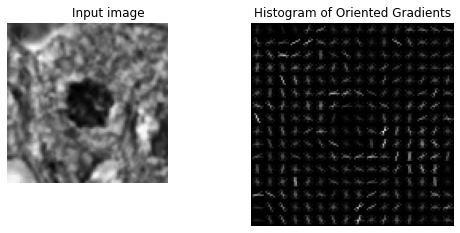

In [8]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

(15876,)


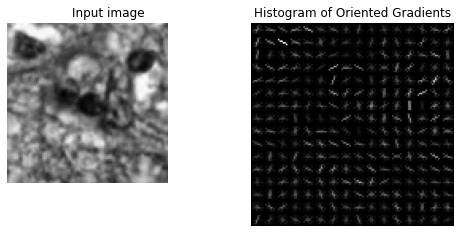

In [9]:
img = io.imread(r"/content/MandNM/nonmitosis/A00_01_01_VX9XQ1HO9-c9862dc6a1df71ff47c2f543a819cffe.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

In [10]:
category = []
hogArray = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = cv2.imread(image)
            image_grey = color.rgb2gray(img)

            # Resize the image to (64, 128)
            # Default for hog
            resized = cv2.resize(image_grey, (128, 128), interpolation=cv2.INTER_AREA)

            # Compute the Hog Features
            fd, hog_image = hog(resized,visualize=True)
            
            category.append(folder)
            hogArray.append(fd)



# convert the extracted features
# from array to vector
hogArray_np = np.array(hogArray)


print("Total feature extracted from the each image",len(hogArray_np[0]))

Total feature extracted from the each image 15876


In [11]:
hog_features=pca_reduction(hogArray_np)

In [12]:
csvData = []
for id, line in enumerate(hog_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_hog_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [13]:
import pandas as pd

feature_hog=pd.read_csv("result_hog_data.csv")
feature_hog['label'] = feature_hog['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_hog

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value161,value162,value163,value164,value165,value166,value167,value168,value169,value170,value171,value172,value173,value174,value175,value176,value177,value178,value179,value180,value181,value182,value183,value184,value185,value186,value187,value188,value189,value190,value191,value192,value193,value194,value195,value196,value197,value198,value199,label
0,-0.157750,-1.270229,-0.053022,-1.328376,-0.677471,0.952796,-0.271832,0.030353,-0.135466,-0.391462,-1.252982,-0.541767,-0.925771,0.002430,0.246106,-0.071998,0.444462,-0.123407,-0.006899,-1.253048,0.982925,-0.449209,-0.002212,-0.135863,-0.491615,-1.155554,0.134184,0.767808,0.165960,-0.015993,0.692399,-1.415408,-0.520480,-0.115761,0.866648,-0.164653,-0.292248,-0.298763,-0.938161,0.107075,...,0.407416,-0.111800,0.412776,0.441782,-0.399922,0.786908,0.388995,0.465896,-0.146448,-0.190110,0.225743,-0.489514,0.273572,0.522037,-0.524442,-0.141490,0.655599,-0.093716,0.066410,-0.449767,0.430143,0.022095,-0.242703,0.132190,-0.074271,0.651301,0.316484,-0.441706,0.219685,0.214730,0.203772,0.024169,-0.321107,0.222336,-0.388171,0.292940,-0.842367,0.002138,0.008257,0
1,-0.097484,-0.378101,0.348075,1.484195,-0.691245,-0.105842,-0.224682,0.531779,-0.431257,-0.484140,-0.354867,-0.495500,1.181338,-1.036245,0.371811,1.215908,-0.204168,-0.745438,-0.882422,-0.373499,-0.636156,-0.195739,-0.765978,0.370376,-1.163445,-0.403754,-0.348185,0.463696,-0.127835,-1.090115,1.734727,-1.315749,0.599185,-1.059631,-0.155245,1.240812,1.673823,0.350745,0.795749,-0.069845,...,-0.041644,0.417994,-0.139228,0.305807,-0.234921,0.264546,0.505983,-0.068933,0.122719,0.263825,0.305746,-0.738433,0.303695,0.056608,0.650241,-0.328883,-0.132166,0.061142,-0.855466,0.346270,-0.024972,0.232704,-0.087029,0.312462,0.775244,0.816094,0.147207,-0.234061,0.068659,0.560325,0.598295,-0.174964,0.190494,-0.145941,0.212746,-0.244214,0.315016,0.503158,0.068443,0
2,-0.217460,-1.216051,-0.203627,0.842113,-2.082421,0.417374,0.879943,-0.634145,-0.159897,-0.363098,-0.110970,-0.356055,-0.397707,-0.479816,0.193150,-0.710114,0.409318,-0.145330,-0.717088,-0.777857,-0.341648,0.358400,1.079514,1.223618,0.143211,0.126685,-0.823387,-0.187755,-0.812290,0.038542,0.029476,0.500647,-0.227118,0.476508,-0.476781,0.704067,-0.218706,0.348516,0.042739,-0.637682,...,0.666672,0.164633,-0.278597,0.010516,0.214834,0.194567,-0.045997,-0.058488,-0.054092,-0.334801,0.587538,0.250170,-0.198973,0.902712,-0.325467,0.190279,0.479060,0.471770,-0.115621,0.334276,0.726092,-0.522487,0.073907,0.429619,-0.510373,0.057722,-0.000850,0.491890,-0.547589,-0.365171,-0.119237,0.402399,0.193749,0.847869,-0.421566,-0.298702,0.598243,-0.536460,0.047837,0
3,-2.404491,0.327681,1.372869,-0.238148,0.749279,1.584349,-0.756199,-0.443357,0.399354,-0.478647,-0.708158,-0.231727,0.134367,0.595689,-0.047095,-0.112845,0.966625,-0.291297,0.169055,0.201256,-0.367009,-1.035159,0.314314,0.393425,-0.069563,0.372997,-0.434355,0.151886,-0.015754,-0.032527,0.149851,2.052073,-0.504454,-0.843223,-0.154727,-0.725007,-0.049639,0.217236,-0.079241,0.158293,...,-0.266208,-0.559575,0.295957,-0.055052,-0.169422,-0.448970,-0.890582,-0.550165,-0.141942,0.530623,-0.277149,-0.238666,-0.197410,-0.059665,0.082907,-0.820243,0.278418,0.357670,-0.166009,-0.366449,-0.449177,0.380984,0.561540,0.361965,0.223481,-0.277272,0.263065,-0.067354,0.466885,-0.253197,-0.635925,0.050576,-0.209981,-0.253741,0.159346,0.449973,-0.362137,0.175397,0.060334,0
4,-0.084632,-0.191901,0.508375,0.700406,-0.905723,-0.202108,0.742135,1.496992,-1.090924,0.277262,-0.699202,0.415574,0.762993,0.286143,0.001494,-0.892307,-0.289056,0.458420,-0.465253,-0.835305,0.213304,-0.770610,0.279527,-0.381154,0.047104,-0.091719,-0.013704,0.508380,-0.405011,-0.101

### classification based on features

In [14]:
print("results for gridsearch:")
grid_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:79.3103448275862',
 'KNN:0.5971014492753622',
 'svm:85.0574712643678']

In [15]:
print("results for random search")
random_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 9, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 81}
The KNN Model is trained well with the given images {'n_neighbors': 1}
The svm Model is trained well with the given images {'C': 0.5926952171433575, 'kernel': 'rbf'}


['Random forest:0.7217391304347825',
 'KNN:0.6115942028985507',
 'svm:0.8115942028985508']

In [ ]:
print("results for hyperband")
hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [22]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 32), ('min_samples_leaf', 11), ('min_samples_split', 11), ('n_estimators', 99)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 1)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])


['Random forest:0.7565217391304347',
 'KNN:0.6115942028985507',
 'svm:0.8057971014492754']

In [28]:
print("results for skopt")
skopt_gp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7594202898550725',
 'KNN:-0.553623188405797',
 'svm:0.7971014492753623']

In [34]:
print("result for bo_tpe")
bo_tpe(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.86it/s, best loss: -0.7971014492753623]


["Random forest:{'criterion': 1, 'max_depth': 22.0, 'max_features': 47.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 59.0}",
 "KNN:{'n_neighbors': 9.0}",
 "svm:{'C': -34.897388949898065, 'kernel': 2}"]

In [38]:
print("result for genetic")
genetic(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	10    	0.649565	0.544928	0.750725	0.0723646
1  	6     	0.72029 	0.605797	0.747826	0.0403149
2  	6     	0.730435	0.704348	0.747826	0.0164478
3  	8     	0.738841	0.713043	0.747826	0.00982519
4  	2     	0.745217	0.742029	0.747826	0.00156092
5  	8     	0.735652	0.704348	0.747826	0.0158654 
Best individual is: {'n_estimators': 78, 'max_features': 55, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'gini'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'n_estimators': 78, 'max_features': 55, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.535652	0.518841	0.55942	0.0108299
1  	8     	0.546087	0.536232	0.55942	0.00899952
2  	5     	0.556812	0.533333	0.55942	0.00782609
3  	4     	0.55942 	0.55942 	0.55942	0         
4  	3     	0.55942 	0.55942 	0.55942	0         
5  	8     	0.55942 	0.55942 	0.55942	0         
Best individual is: {'n_neighbors': 5}
with fitness: 0.5594202898550724
The knn Model is trained well with the given images {'n_neighbors': 5}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.633623	0.501449	0.797101	0.111255
1  	7     	0.69913 	0.501449	0.797101	0.10486 
2  	9     	0.767536	0.713043	0.797101	0.036888
3  	2     	0.797101	0.797101	0.797101	0       
4  	7     	0.797101	0.797101	0.797101	0       
5  	4     	0.797101	0.797101	0.797101	0       
Best individual is: {'C': 15.75759815824494, 'kernel': 'rbf'}
with fitness: 0.7971014492753623
The rf Model is trained well with the given images {'C': 15.75759815824494, 'kernel': 'rbf'}


['Random forest:0.7507246376811594',
 'Random forest:0.5594202898550724',
 'svm:0.7971014492753623']

In [42]:
print("result for tpot")
tpot(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7536231884057972	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=61, RandomForestClassifier__max_features=39, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=77)

Generation 2 - Current Pareto front scores:

-1	0.7681159420289855	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=96)

Generation 3 - Current Pareto front scores:

-1	0.7681159420289855	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=48, RandomForestClassifier__min_samples_lea

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6115942028985507	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 2 - Current Pareto front scores:

-1	0.6115942028985507	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6115942028985507	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=44.71286756712974, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=44.71286756712974, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=44.71286756712974, SVC__kernel=rbf)


['Random forest:81.60919540229885',
 'knn:57.47126436781609',
 'svm:83.9080459770115']

## ORB(Oriented FAST and Rotated BRIEF)
ORB is an efficient open source alternative to SIFT and SURF. Even though it computes less key points when compared to SIFT and SURF yet they are effective. It uses FAST and BRIEF techniques to detect the key points and compute the image descriptors respectively.